# Sparkify Project Introdution
This workspace contains a tiny subset (231MB) of the full dataset available (12GB). Using the IBM Cloud tools, it was possible to use and learn about the spark tool, using pyspark to consult data filtering, treatment and cleaning, or better, pre processing. After this stage, we performed an exploratory analysis of the data and, in sequence, feature engineering. Finally, data modeling and tests were performed

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200704213837-0000
KERNEL_ID = fc451f91-961a-41f5-b449-8f2d213db428


In [9]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparikfy") \
    .config("spark.default.parallelism", 1000) \
    .config("spark.sql.shuffle.partitions", 8) \
    .getOrCreate()

In [10]:
import pyspark
from pyspark import SparkConf
SparkConf().getAll()

[('spark.dynamicAllocation.enabled', 'false'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.driver.host', '172.30.131.16'),
 ('spark.network.crypto.keyLength', '256'),
 ('spark.shuffle.service.enabled', 'false'),
 ('spark.master',
  'spark://jkg-deployment-fc451f91-961a-41f5-b449-8f2d213db428-6b798f8xnl8:7077'),
 ('spark.network.crypto.enabled', 'true'),
 ('spark.driver.memory', '4g'),
 ('spark.executor.extraClassPath',
  '/usr/local/share/jupyter/kernels/scala/lib/*:/home/spark/shared/user-libs/spark2/*:/home/spark/shared/user-libs/common/*:/home/spark/shared/user-libs/connectors/*:/opt/ibm/connectors/db2/*:/opt/ibm/connectors/others-db-drivers/*:/opt/ibm/third-party/libs/spark2/*:/opt/ibm/third-party/libs/common/*:/opt/ibm/third-party/libs/connectors/*'),
 ('spark.driver.extraJavaOptions',
  ' -Dderby.system.home=/home/spark/.local/share/jupyter/runtime/kernel-fc451f91-961a-41f5-b449-8f2d213db428-20200704_213552 -Dlog4j.logFile=/home/spark/shared/logs/kernel-python3.6-python3.6-2020

# Load and Clean Dataset
In this workspace, the dataset is `medium_sparkify_event_data.json`. Load and clean the dataset, checking for missing data

In [11]:
df_data_1.createOrReplaceTempView("data")

In [12]:
#checking for any missing userId's or sessionId's, none
spark.sql('''
        select *
        from data


''').printSchema()

spark.sql('''
        select *
        from data
        where userId is null or sessionId is null
''').show()

#noticed that there were null songs, that is when page's value is not'next song'
spark.sql('''
        select distinct page
        from data
        where song is not null
''').show(40)



root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+----

In [13]:
#Looking as pandas df
spark.sql('''
        select *
        from data


''').toPandas().head()


,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1.532064e+12,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",293
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1.538070e+12,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98
2,Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1.535953e+12,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
3,None,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1.535953e+12,178,None,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
4,Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1.535931e+12,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,246


# Exploratory Data Analysis
When working with the complete data set, we can first run EDA by loading a small subset of the data and doing basic Spark manipulations.

We will create a `Churn` column to use as a label for our model. We will use the `Confirmation of cancellation` events to set the churn, which happens for paid and free users and more.

Once we defined churn, we'll perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. 

In [14]:
#converting timestamp to complete datetime 
spark.udf.register("minute", lambda x: str(datetime.datetime.fromtimestamp(x / 1000.0).minute))
spark.udf.register("seconds", lambda x: str(datetime.datetime.fromtimestamp(x / 1000.0).second))
spark.udf.register("date", lambda x: str(datetime.datetime.fromtimestamp(x / 1000.0)))

<function __main__.<lambda>>

In [15]:
spark.sql('''
        select *, minute(ts) as minute, seconds(ts) as seconds, date(ts) as date, date(registration) as registrationdate
        from data
        where userId != ''
        order by userId, sessionId, ts asc
''')

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, minute: string, seconds: string, date: string, registrationdate: string]

In [17]:
#the ratio of time spent listening songs vs spent in the in between stages
time_data = spark.sql('''
          select *, unix_timestamp(datesntimes) - unix_timestamp(previous_datetime) as timediffinsecs
              From (select *, LAG(datesntimes) OVER (
                PARTITION BY userid, sessionid 
                ORDER BY datesntimes) previous_datetime
                from (
                    select userId, sessionId,page, CAST(date(ts) as timestamp) as datesntimes
                    from data
                    where userId != ''
                    order by userId, sessionId, ts asc))
    
                order by datesntimes
               
''')

time_data.createOrReplaceTempView("time_data")


listening = spark.sql("""
        
        select userid, ifnull(sum(total_time_non_listening),0) as no_listen_time, ifnull(sum(total_time_per_session),0) as total_time, ifnull(sum(total_time_non_listening/total_time_per_session),0) as listening_ratio
        from(
            select abc.userid, abc.sessionid, abc.total_time_per_session, b.total_time_non_listening
            from
                (select userid, sessionid, sum(timediffinsecs) as total_time_per_session
                from time_data
                group by userid, sessionid
                order by sessionid) abc

                left join (select userid, sessionid, sum(timediffinsecs) as total_time_non_listening
                    from time_data
                    where page != 'NextSong'
                    group by userid, sessionid
                    order by sessionid) as b 
            on abc.userid = b.userid and abc.sessionid = b.sessionid
            order by userid, sessionid asc)
           group by userid
           order by userid
        
""")
listening.createOrReplaceTempView("listening_vectors")

In [18]:
#create a vector to use for the models turning the data into one user per row 

pivot_data = spark.sql('''
        
        select userId, sessionId, page, count(page) as page_count
        from data
        where userId != ""
        group by userId, sessionId, page
        order by userId, sessionId, page_count desc
        

''')
pivot_data.createOrReplaceTempView("pivot_data")

transformed_data = spark.sql('''
            select userId, sessionId,
                sum(CancellationConfirmation) as CancellationConfirmation,
                sum(SubmitUpgrade) as SubmitUpgrade,
                sum(Upgrade) as Upgrade,
                sum(Cancel) as Cancel,
                sum(ThumbsUp) as ThumbsUp,
                sum(Help) as Help,
                sum(NextSong) as NextSong,
                sum(AddFriend) as AddFriend,
                sum(AddtoPlaylist) as AddtoPlaylist,
                sum(Settings) as Settings,
                sum(About) as About,
                sum(ThumbsDown) as ThumbsDown,
                sum(SaveSettings) as SaveSettings,
                sum(Logout) as Logout,
                sum(RollAdvert) as RollAdvert,
                sum(Downgrade) as Downgrade,
                sum(Home) as Home,
                sum(SubmitDowngrade) as SubmitDowngrade
                
                
                from (select pivot_data.*,
                    case when page = "Cancellation Confirmation" then page_count else 0 end as CancellationConfirmation,
                    case when page = "Submit Upgrade" then page_count  else 0 end as SubmitUpgrade,
                    case when page = "Upgrade" then page_count  else 0 end as Upgrade,
                    case when page = "Cancel" then page_count  else 0 end as Cancel
                    case when page = "Thumbs Up" then page_count  else 0 end as ThumbsUp,
                    case when page = "Help" then page_count  else 0 end as Help,
                    case when page = "NextSong" then page_count  else 0 end as NextSong,
                    case when page = "Add Friend" then page_count  else 0 end as AddFriend,
                    case when page = "Add to Playlist" then page_count  else 0 end as AddtoPlaylist,
                    case when page = "Settings" then page_count  else 0 end as Settings,
                    case when page = "About" then page_count  else 0 end as About,
                    case when page = "Thumbs Down" then page_count  else 0 end as ThumbsDown,
                    case when page = "Save Settings" then page_count  else 0 end as SaveSettings,
                    case when page = "Logout" then page_count  else 0 end as Logout,
                    case when page = "Roll Advert" then page_count  else 0 end as RollAdvert,
                    case when page = "Downgrade" then page_count  else 0 end as Downgrade,
                    case when page = "Home" then page_count  else 0 end as Home,
                    case when page = "Submit Downgrade" then page_count  else 0 end as SubmitDowngrade,
                    
                from pivot_data) pivot_ext
                group by userId, sessionId
                order by userId, sessionId asc
''')
transformed_data.createOrReplaceTempView("transformed_vectors")



transform_vector = spark.sql('''
        select userId, sum(CancellationConfirmation) as CancellationConfirmation,
                sum(SubmitUpgrade) as SubmitUpgrade,
                sum(Upgrade) as Upgrade,
                sum(Cancel) as Cancel
                sum(ThumbsUp) as ThumbsUp,
                sum(Help) as Help,
                sum(NextSong) as NextSong,
                sum(AddFriend) as AddFriend,
                sum(AddtoPlaylist) as AddtoPlaylist,
                sum(Settings) as Settings,
                sum(About) as About,
                sum(ThumbsDown) as ThumbsDown,
                sum(SaveSettings) as SaveSettings,
                sum(Logout) as Logout,
                sum(RollAdvert) as RollAdvert,
                sum(Downgrade) as Downgrade,
                sum(Home) as Home,
                sum(SubmitDowngrade) as SubmitDowngrade,
                
        from transformed_vectors
        group by userId
''')
transform_vector.createOrReplaceTempView("transform_vector")

In [19]:
#each user number of sessions
num_sessions = spark.sql('''
        
        select userId, count(*) as sessions
        FROM (select distinct userId, sessionId
                from data
                where userId != "")
        group by userId
        order by sessions Desc
        

''')

num_sessions.createOrReplaceTempView('num_vectors')

In [20]:
#bring all the different engineered features into one table

feature_engineered = spark.sql('''
                select trans.*, listen.no_listen_time, listen.total_time, listen.listening_ratio, num_sess.sessions 
                    from listening_vectors listen
                left join num_vectors num_sess
                on listen.userid = num_sess.userid
                left join transform_vector trans
                on trans.userid = listen.userid
                where listen.no_listen_time is not null or listen.total_time is not null                
''')

#user 135 only has 1 session and they listen to 6 songs but engage in no other activities, so I removed the id
# with the WHERE statement

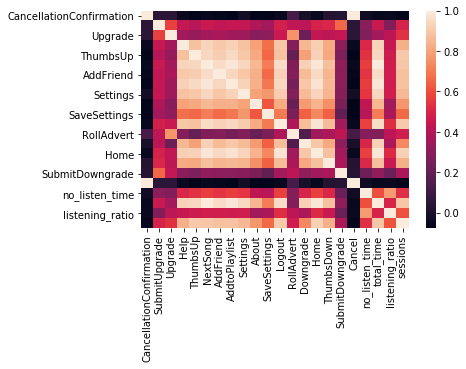

In [21]:
sns.heatmap(feature_engineered.toPandas().corr())

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [22]:
from pyspark.ml.feature import VectorAssembler


columns_ignore = ['userId',"CancellationConfirmation", 'Cancel' ]

assembler_page_vector = VectorAssembler(
  inputCols=[x for x in feature_engineered.columns if x not in columns_ignore], outputCol="features"
)

assembled = assembler_page_vector.transform(feature_engineered)

In [23]:
final = assembled.select(['userId','features',"CancellationConfirmation"])

In [25]:
splits = final.randomSplit([0.7, 0.3], seed=42)
train_df = splits[0]
test_val = splits[1]

In [26]:
#classes ratio
print (train_df.toPandas()['CancellationConfirmation'].value_counts())
print (test_val.toPandas()['CancellationConfirmation'].value_counts())

0    244
1     64
Name: CancellationConfirmation, dtype: int64
0    105
1     35
Name: CancellationConfirmation, dtype: int64


In [27]:
#scaling the vectors to logisitic regression classifier
#seperating the train and test

from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scalerModel = scaler.fit(train_df)

scaledData = scalerModel.transform(train_df)

In [28]:
train_df_sampled = scaledData.sampleBy("CancellationConfirmation", fractions= {0: 1.0, 1: 1.0 })
train_df_sampled.createOrReplaceTempView("train")

In [29]:
#adding weights
spark.udf.register("weight", lambda x: (x+1)*0.23 if x == 0 else 1)

train_df_model = spark.sql('''
            select *, cast(weight(CancellationConfirmation) as float) as weight
            from train
''')


# Modeling


In [30]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

lr = LogisticRegression( featuresCol="scaledFeatures", labelCol="CancellationConfirmation", weightCol="weight")

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="CancellationConfirmation", metricName= "f1")

pipeline = Pipeline(stages=[]) 

lr_stages = [lr]

lr_pipeline = Pipeline(stages=lr_stages)

paramGrid = ParamGridBuilder() \
    .baseOn({pipeline.stages:lr_stages})  \
    .addGrid(lr.maxIter, [200, ]) \
    .addGrid(lr.elasticNetParam, [0]) \
    .addGrid(lr.threshold, [0.6]) \
    .build()


crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2) 

cvModel = crossval.fit(train_df_model)


In [31]:
sc_test = scalerModel.transform(test_val)

prediction = cvModel.transform(scaledtest)

In [32]:
cvModel.bestModel

PipelineModel_93ead28fb6c1

In [ ]:
best_Pipeline = cvModel.bestModel.stages[-1]

best_Params = bestPipeline.extractParamMap()

In [35]:
print ("The precision for validation set is {}".format(evaluator.evaluate(prediction, {evaluator.metricName: "weightedPrecision"})))
print ("The recall for validation set is {}".format(evaluator.evaluate(prediction, {evaluator.metricName: "weightedRecall"})))
print ("The f1 for validation set is {}".format(evaluator.evaluate(prediction, {evaluator.metricName: "f1"})))

The precision for validation set is 0.7023391812865497
The recall for validation set is 0.6714285714285715
The f1 for validation set is 0.68375


In [36]:
result = prediction.toPandas()

print ("False positives: {} ".format(len(result[(result['prediction'] == 1) & (result['CancellationConfirmation'] == 0)])))
print ("False negatives: {} ".format(len(result[(result['prediction'] == 0) & (result['CancellationConfirmation'] == 1)])))
print ("True Negatives: {} ".format(len(result[(result['prediction'] == 0) & (result['CancellationConfirmation'] == 0)])))
print ("True positives: {} ".format(len(result[(result['prediction'] == 1) & (result['CancellationConfirmation'] == 1)])))

result[(result['prediction'] == 1) & (result['CancellationConfirmation'] == 0)]

140
False positives: 28 
False negatives: 18 
True Negatives: 77 
True positives: 17 


,userId,features,CancellationConfirmation,scaledFeatures,rawPrediction,probability,prediction
4,157,"[2.0, 6.0, 12.0, 115.0, 2500.0, 44.0, 54.0, 15...",0,"[2.8018549657859677, 2.341933266893553, 1.5402...","[-4.295033049902546, 4.295033049902546]","[0.013452678663105637, 0.9865473213368944]",1.0
5,200043,"[1.0, 4.0, 3.0, 33.0, 615.0, 12.0, 23.0, 10.0,...",0,"[1.4009274828929839, 1.561288844595702, 0.3850...","[-1.3392602043636443, 1.3392602043636443]","[0.2076317440064704, 0.7923682559935296]",1.0
6,210,"[1.0, 1.0, 2.0, 13.0, 255.0, 4.0, 10.0, 3.0, 1...",0,"[1.4009274828929839, 0.3903222111489255, 0.256...","[-1.048215794754902, 1.048215794754902]","[0.25956786435512336, 0.7404321356448766]",1.0
12,127,"[2.0, 2.0, 12.0, 98.0, 1921.0, 31.0, 48.0, 18....",0,"[2.8018549657859677, 0.780644422297851, 1.5402...","[-1.780963110910637, 1.780963110910637]","[0.14418425014200603, 0.855815749857994]",1.0
21,259,"[2.0, 3.0, 21.0, 140.0, 3029.0, 47.0, 94.0, 25...",0,"[2.8018549657859677, 1.1709666334467765, 2.695...","[-0.5975833407193295, 0.5975833407193295]","[0.3548967817508829, 0.6451032182491171]",1.0
25,48,"[1.0, 2.0, 3.0, 19.0, 302.0, 8.0, 6.0, 1.0, 0....",0,"[1.4009274828929839, 0.780644422297851, 0.3850...","[-0.9896529879171131, 0.9896529879171131]","[0.2709806244829903, 0.7290193755170097]",1.0
37,200040,"[0.0, 0.0, 3.0, 15.0, 335.0, 9.0, 9.0, 5.0, 0....",0,"[0.0, 0.0, 0.38505847788024455, 0.204894672585...","[-0.4902775522841969, 0.4902775522841969]","[0.3798281856116102, 0.6201718143883899]",1.0
41,294,"[1.0, 1.0, 8.0, 94.0, 1720.0, 29.0, 44.0, 6.0,...",0,"[1.4009274828929839, 0.3903222111489255, 1.026...","[-1.5848536254692138, 1.5848536254692138]","[0.17010918823043986, 0.8298908117695601]",1.0
50,173,"[1.0, 15.0, 11.0, 70.0, 1445.0, 30.0, 42.0, 6....",0,"[1.4009274828929839, 5.854833167233883, 1.4118...","[-0.41679262924953586, 0.41679262924953586]","[0.397284499950534, 0.6027155000494661]",1.0
53,200006,"[1.0, 4.0, 2.0, 38.0, 491.0, 8.0, 11.0, 1.0, 2...",0,"[1.4009274828929839, 1.561288844595702, 0.2567...","[-1.7407338070414158, 1.7407338070414158]","[0.14921975138451782, 0.8507802486154822]",1.0
